In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from useful_functions.plotter import plot

idx = pd.IndexSlice

In [2]:
sns.set_style("ticks")
sns.set_context("paper",font_scale=2.0)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

import matplotlib
import matplotlib.pyplot as plt
font = {'family': 'serif', 'serif': ['Gentium Basic'], 'size': 10}
plt.rc('font', **font)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Gentium Basic'
matplotlib.rcParams['mathtext.it'] = 'Gentium Basic:italic'
matplotlib.rcParams['mathtext.bf'] = 'Gentium Basic:bold'

from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

pgf_with_custom_preamble = {
"font.family": "serif", # use serif/main font for text elements
"text.usetex": False,    # use inline math for ticks
"pgf.preamble": [
    "\\usepackage{mathpazo}",
    "\\usepackage{gentium}",
    "\\DeclareSymbolFont{sfnumbers}{T1}{gentium}{m}{n}",
    "\\SetSymbolFont{sfnumbers}{bold}{T1}{gentium}{bx}{n}",
    "\\DeclareMathSymbol{0}\mathalpha{sfnumbers}{\"30}",
    "\\DeclareMathSymbol{1}\mathalpha{sfnumbers}{\"31}",
    "\\DeclareMathSymbol{2}\mathalpha{sfnumbers}{\"32}",
    "\\DeclareMathSymbol{3}\mathalpha{sfnumbers}{\"33}",
    "\\DeclareMathSymbol{4}\mathalpha{sfnumbers}{\"34}",
    "\\DeclareMathSymbol{5}\mathalpha{sfnumbers}{\"35}",
    "\\DeclareMathSymbol{6}\mathalpha{sfnumbers}{\"36}",
    "\\DeclareMathSymbol{7}\mathalpha{sfnumbers}{\"37}",
    "\\DeclareMathSymbol{8}\mathalpha{sfnumbers}{\"38}",
    "\\DeclareMathSymbol{9}\mathalpha{sfnumbers}{\"39}",
    "\\DeclareMathSymbol{,}\mathalpha{sfnumbers}{\"2C}"
    ]
}
matplotlib.rcParams.update(pgf_with_custom_preamble)

/home/sbg/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [3]:
import matplotlib.font_manager
list = matplotlib.font_manager.get_fontconfig_fonts()
names = [matplotlib.font_manager.FontProperties(fname=fname).get_name() for fname in list]
print(names)

['URW Bookman', 'Liberation Sans', 'Liberation Mono', 'Gentium Book Basic', 'Lato', 'Lato', 'Noto Mono', 'Source Code Variable', 'Gentium Basic', 'Nimbus Sans Narrow', 'Liberation Sans Narrow', 'Nimbus Mono PS', 'Source Code Pro', 'Liberation Sans Narrow', 'Courier New', 'Nimbus Sans', 'P052', 'Georgia', 'D050000L', 'Source Code Pro', 'Times New Roman', 'Webdings', 'Times New Roman', 'Liberation Sans', 'Nimbus Roman', 'Courier New', 'Source Code Variable', 'Verdana', 'Source Code Pro', 'Impact', 'Trebuchet MS', 'Source Code Variable', 'DejaVu Sans', 'Source Code Variable', 'Gentium', 'Lato', 'Arial', 'Lato', 'Trebuchet MS', 'P052', 'Source Code Variable', 'Georgia', 'Gentium Basic', 'Liberation Mono', 'Source Code Pro', 'Source Code Pro', 'Source Code Pro', 'Liberation Serif', 'Arial', 'Courier New', 'Georgia', 'Source Code Variable', 'Source Code Pro', 'Nimbus Sans', 'Source Code Pro', 'Verdana', 'Arial', 'Source Code Pro', 'Arial Black', 'Arial', 'Source Code Pro', 'Source Code Varia

In [4]:
notification = pd.read_csv('../data/EU/notification.csv')
stringency = pd.read_csv('../data/Global/OxCGRT_latest.csv')
pca = pd.read_csv('EU_pca.csv')

# The PCA data doesn't include anything for Czechia or Malta, so we will drop those
# Canyao removed Croatia because of the abnormal spike along PC1

# countries is the list of names that we choose to use (removed "Czechia" and "Malta" and "Croatia")
countries = ["Austria", "Belgium", "Bulgaria", "Denmark", "France", "Germany",
             "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Netherlands",
             "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden", "United Kingdom"]

# countries stringency uses a few different names, which we originally use for masking, but then change names afterwards
# (removed "Czech Republic" and "Malta")
countries_stringency = ["Austria", "Belgium", "Bulgaria", "Denmark", "France", "Germany",
                        "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Netherlands",
                        "Poland", "Portugal", "Romania", "Slovak Republic", "Slovenia", "Spain", "Sweden", "United Kingdom"]

/home/sbg/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# Stringency

jur_msk = stringency['Jurisdiction'] == 'NAT_TOTAL'
stringency = stringency[jur_msk]

country_msk = stringency['CountryName'].isin(countries_stringency)

stringency = stringency.loc[country_msk, ['CountryName', 'Date', 'ContainmentHealthIndex']]

stringency['Date'] =  pd.to_datetime(stringency['Date'], format='%Y%m%d')
date_msk = stringency['Date'] <= '2020-12-22'
stringency = stringency[date_msk]

date_msk = stringency['Date'] >= '2020-01-01'
stringency = stringency[date_msk]

# replace instances of two different named countries
stringency.loc[stringency['CountryName'] == 'Slovak Republic', 'CountryName'] = 'Slovakia'
stringency.loc[stringency['CountryName'] == 'Czech Republic', 'CountryName'] = 'Czechia'

stringency = stringency.reset_index(drop=True).set_index(['CountryName','Date'])

assert stringency['ContainmentHealthIndex'].isna().sum() == 0

weekly_stringency = stringency.groupby([pd.Grouper(level='CountryName'), 
                                        pd.Grouper(freq='7D', level='Date', label='left')]).mean()

weekly_stringency.index = pd.MultiIndex.from_arrays([weekly_stringency.index.get_level_values(0),
                                                     weekly_stringency.index.get_level_values(1).week],
                                                    names=['country', 'week'])

# NOTE: The weekly data runs from Jan 1 (Wednesday) to Dec 22 (Tuesday), constituing 51 weeks that run Wed->Tues

<ipython-input-5-83902eab9120>:29: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  weekly_stringency.index.get_level_values(1).week],


In [6]:
country_msk = notification['country'].isin(countries)

notification = notification[country_msk]

notification = notification.drop(columns=['country_code', 'continent', 'source'])

notification = notification.reset_index(drop=True).set_index(['country','year_week'])

case_msk = notification['indicator'] == 'cases'
death_msk = notification['indicator'] == 'deaths'

deaths = notification[death_msk]
deaths = deaths.rename(columns={'weekly_count' : 'death_weekly_count', 'rate_14_day' : 'death_rate_14_day', 
                        'cumulative_count' : 'death_cumulative_count'})

cases = notification[case_msk]
cases = cases.rename(columns={'weekly_count' : 'case_weekly_count', 'rate_14_day' : 'case_rate_14_day', 
                        'cumulative_count' : 'case_cumulative_count'})

In [7]:
notification = cases.join(deaths.loc[:,['death_weekly_count', 'death_rate_14_day', 'death_cumulative_count']])
notification = notification.drop(columns=['indicator'])

notification.index = pd.MultiIndex.from_arrays([notification.index.get_level_values(0),
                                               [int(x[5:]) for x in notification.index.get_level_values(1)]],
                                               names=['country', 'week'])

In [8]:
total = weekly_stringency.join(notification)
total.loc[:,'population'] = total.groupby('country')['population'].fillna(method='bfill')

# NOTE: All remaining NaNs are because of first few weeks in some countries that didn't report before their first case
# OR for all countries the first week 14-day rate is NaN since it is ill-defined. We can still set it to zero,
# since there were no cases before Jan 1 anyway

total = total.fillna(0)

In [9]:
pca = pca.loc[:, ['region', 'date', 'pca_0']]

pca['date'] =  pd.to_datetime(pca['date'])
date_msk = pca['date'] <= '2020-12-22'
pca = pca[date_msk]

date_msk = pca['date'] >= '2020-02-26' # first date in each is 2020-02-21, first week begins on Feb 26th
pca = pca[date_msk]

pca = pca.rename(columns={'region' : 'country', 'pca_0' : 'sdi'})

pca = pca.reset_index(drop=True).set_index(['country','date'])

assert pca['sdi'].isna().sum() == 0

# impute missing dates via forward fill

pca = pca.reset_index().pivot(index='date', columns='country', values='sdi').fillna(method='ffill').T.stack()

In [10]:
weekly_pca = pca.groupby([pd.Grouper(level='country'), 
                          pd.Grouper(freq='7D', level='date', label='left')]).mean()

weekly_pca.index = pd.MultiIndex.from_arrays([weekly_pca.index.get_level_values(0),
                                              weekly_pca.index.get_level_values(1).week],
                                              names=['country', 'week'])

<ipython-input-10-e562812e122b>:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  weekly_pca.index.get_level_values(1).week],


In [11]:
weekly_pca = pca.groupby([pd.Grouper(level='country'), 
                          pd.Grouper(freq='7D', level='date', label='left')]).mean()

weekly_pca.index = pd.MultiIndex.from_arrays([weekly_pca.index.get_level_values(0),
                                              weekly_pca.index.get_level_values(1).week],
                                              names=['country', 'week'])

weekly_pca.name = 'sdi'

# rescale to go from 0 to 100 and flip the sign so that higher means more socially distance
weekly_pca = -1 * weekly_pca
weekly_pca = 100. * (weekly_pca - weekly_pca.min()) / (weekly_pca.max() - weekly_pca.min())

<ipython-input-11-36359fbe73a6>:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  weekly_pca.index.get_level_values(1).week],


In [12]:
final = total.join(weekly_pca)

final = final.dropna() # this drops weeks 1-8 since we don't have SDI data there

# Thus, the final dataset runs from Feb 26 2020 (week 9) through Dec 22 (end of week 51), so there are 43 weeks

# NOTE: We may still add Croatia back in pending Canyao

# Otherwise, there are 22 countries, 43 weeks

Text(0.5, 0, 'Test')

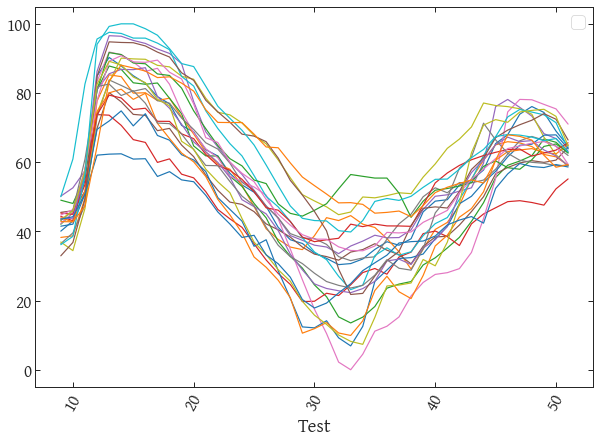

In [13]:
fig, ax = plot(figsize=(10,7))

for i,c in enumerate(countries):
    final.loc[idx[c]].plot(y='sdi', ax=ax)
    
plt.xticks(rotation = 60)
plt.legend([],[])
plt.xlabel(r'Test')

# Looks good

In [591]:
final.to_csv('../data/EU/final_eu_data.csv')